# Code for data analysis - Stern Gerlach

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

### Reading data and loading list

Read the output files and save the average trajectories.

Each output file refer to a point in phase-space, and it is labelled in (q,p).

Iside each file, we store:

- u0 : population of ground state
- u1 : population of first excited state
- coher : coherence

In [2]:
# For this example we already know the points in phase space to consider!
pos = [0.0]
mom = [-0.1,0.0,0.1]

phasespace = []

for q in pos:
    for p in mom:
        
        filename = './output/average_trajectory_pos_{0}_mom_{1}.dat'.format( str(q) , str(p) )
        Qtrajectory_pop = np.loadtxt(filename,
                                     skiprows = 4,
                                     delimiter = ' , ',
                                     usecols = (0,1),
                                     dtype = np.float
                                    )
        Qtrajectory_coher = np.loadtxt(filename,
                                       skiprows = 4,
                                       delimiter = ' , ',
                                       usecols = 2,
                                       dtype = np.complex
                                      )
        point_phasespace = {'pos' : q , 'mom' : p , 'populations' : Qtrajectory_pop , 'coherence' : Qtrajectory_coher}
        phasespace.append(point_phasespace)

### Plot the evolution

We now plot the populations and the coherence on the different points in phase-space.

The parameter `Nmax` defines the maximum time we show.

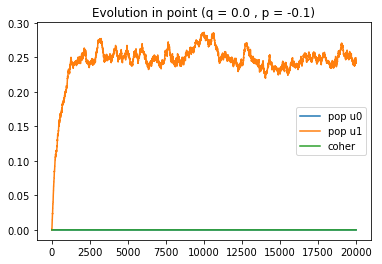

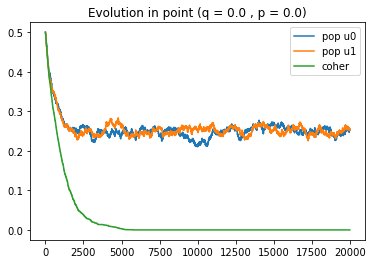

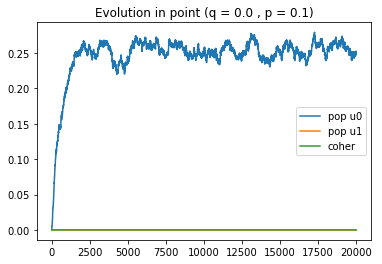

In [4]:
Nmax = 20000

for point in phasespace:
    q = point['pos']
    p = point['mom']
    u0 = point['populations'][:Nmax,0]
    u1 = point['populations'][:Nmax,1]
    coher = map(np.absolute, point['coherence'][:Nmax])
    tit = 'Evolution in point (q = {0} , p = {1})'.format( str(q), str(p) )

    evo_u0, = plt.plot(u0, label='pop u0')
    evo_u1, = plt.plot(u1, label='pop u1')
    evo_coher, = plt.plot(coher, label='coher')
    plt.legend(handles=[evo_u0, evo_u1,evo_coher])
    plt.title(tit)
    plt.show()